In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import pathlib
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import polars as pl

In [21]:
def calculate_wait_times(rts: list, group_type:str, only_daytime:bool = True):

    rt_to_pid = pd.read_parquet("rt_to_pid.parquet")
    pids = rt_to_pid[rt_to_pid['rt'].isin(rts)]['pid'].unique()
    
    trips = []
    for pid in pids:
        try:
            df_trips = pl.read_parquet(f'../cta-stop-etl/out/trips/trips_{pid}_full.parquet')
            df_trips = df_trips.to_pandas()
        except:
            print(f"Do not have pattern {pid} for route {rt}. Skipping")
            continue

        df_trips = df_trips[(df_trips['typ'] == 'S') & (df_trips['bus_stop_time'].dt.hour.between(6, 20) if only_daytime else True)]
        df_trips['pid'] = int(pid)
    
        dict = df_trips.to_dict(orient="records")
        trips += dict

    df_trips_all = pd.DataFrame(trips)

    rt_to_pid = pd.read_parquet('rt_to_pid.parquet') 
    full_df = df_trips_all.merge(rt_to_pid, how="left", on="pid")

    full_df = full_df.sort_values(['p_stp_id','bus_stop_time'])
    full_df['wait_time_minutes'] = full_df.groupby('p_stp_id')['bus_stop_time'].diff().dt.total_seconds()/60


    full_df['month'] = full_df['bus_stop_time'].dt.month
    full_df['hour'] = full_df['bus_stop_time'].dt.hour
    full_df['dayofweek'] = full_df['bus_stop_time'].dt.dayofweek
    full_df['dayofyear'] = full_df['bus_stop_time'].dt.dayofyear


    grouped_df = full_df.groupby(['rt', group_type])['wait_time_minutes'].agg(['mean','median', 'std', 'count']).reset_index()

    grouped_df['ci95_hi'] = grouped_df['mean'] + 1.96*grouped_df['std']/np.sqrt(grouped_df['count'])
    grouped_df['ci95_low'] = grouped_df['mean'] - 1.96*grouped_df['std']/np.sqrt(grouped_df['count'])
        
        
    #     df_trips = df_trips.filter(pl.col('typ') == 'S')
    #     df_trips = df_trips.with_columns(pl.lit(pid).cast(pl.Int64).alias('pid'))
        
    #     dicts = df_trips.to_dicts()
    #     trips.extend(dicts)

    # df_trips_all = pl.DataFrame(trips)
    # rt_to_pid = pl.read_parquet('rt_to_pid.parquet') 

    # full_df = df_trips_all.join(rt_to_pid, on='pid', how='left')

    # full_df = full_df.sort(by=['p_stp_id', 'bus_stop_time'])
    # full_df = full_df.groupby(['p_stp_id']).with_columns(
    #     (pl.col('bus_stop_time').diff().dt.total_seconds() / 60).alias('wait_time_minutes')
    # )

    # full_df = full_df.with_columns((pl.col('bus_stop_time').dt.hour()).alias('hour'), 
    #                   (pl.col('bus_stop_time').dt.month()).alias('month'),
    #                   (pl.col('bus_stop_time').dt.year()).alias('year'),
    #                     (pl.col('bus_stop_time').dt.day()).alias('day'))

    # # Group by 'rt' and 'grouping', and compute aggregations
    # grouped_df = (
    #     full_df
    #     .groupby(['rt', grouping])
    #     .agg([pl.mean('wait_time_minutes').alias('mean'),
    #           pl.median('wait_time_minutes').alias('median'),
    #           pl.std('wait_time_minutes').alias('std'),
    #           pl.count('wait_time_minutes').alias('count')
    #           ])
    # )

    # # Compute the confidence intervals
    # grouped_df = grouped_df.with_columns([
    #     (pl.col('mean') + 1.96 * pl.col('std') / np.sqrt(pl.col('count'))).alias('ci95_hi'),
    #     (pl.col('mean') - 1.96 * pl.col('std') / np.sqrt(pl.col('count'))).alias('ci95_low')
    # ])


    return grouped_df

In [32]:
def chart_wait_times(grouped_df: pd.DataFrame,type:str):
    rts = grouped_df['rt'].unique()
    grouping = test.columns[1]

    plt.figure(figsize=(10, 6))

    # Plot a line for each month
    for rt in rts:
        subset = grouped_df[grouped_df['rt'] == rt]
        plt.plot(subset[grouping], subset[type], marker='o', label=rt)
        if type == 'mean':
            plt.fill_between(subset[grouping], subset['ci95_hi'], subset['ci95_low'], alpha=0.2)

    plt.xlabel(f"{grouping}")
    plt.ylabel(f'{type} Wait Time (Minutes)')
    plt.title(f'{type} Wait Time by {grouping}')
    # plt.ylim(0, 60)
    plt.legend(title='Route')
    plt.grid(True)
    plt.show()

In [22]:
test = calculate_wait_times(['172','6'], 'dayofweek')

In [34]:
test

,rt,dayofweek,mean,median,std,count,ci95_hi,ci95_low
0,172,0,37.082092,13.817394,223.662247,86670,38.571160,35.593025
1,172,1,24.561578,13.615030,84.399802,90135,25.112577,24.010579
2,172,2,25.306889,13.619040,91.759267,90180,25.905784,24.707994
3,172,3,25.035223,13.691926,85.382236,89805,25.593659,24.476787
4,172,4,24.871628,13.405707,84.676484,90312,25.423892,24.319365
5,172,5,69.938715,30.186317,164.073046,24360,71.999130,67.878300
6,172,6,71.357770,30.121476,187.091421,25710,73.644732,69.070808
7,6,0,25.719927,15.108120,73.192652,349280,25.962665,25.477190
8,6,1,25.314970,15.056956,72.680433,355138,25.554012,25.075927
9,6,2,25.485587,15.038351,72.718921,352695,25.725583,25.245591


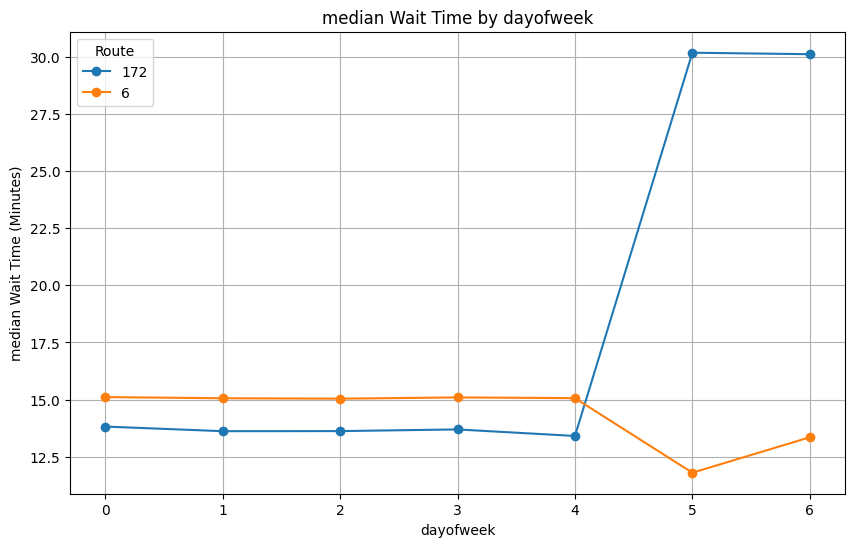

In [33]:
chart_wait_times(test,'median')